# Лабораторная работа №3 Проведение исследований с деревом выбора

## 2. Создание бейзлайн и оценка качества

Возьмём датасеты из прошлой лабораторной и обучим на них новые модели.

В данном блоке мы загружаем датасеты в пандас и приводим их к виду, необходимому для обучения моделей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics


df_class = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/sameepvani/nasa-nearest-earth-objects/versions/2/neo_v2.csv')
df_reg = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/wind_vs_price.csv')

# В классификации избавляемся от столбцов, не влияющих на результат (различные названия и имена)
df_class = df_class.drop(['orbiting_body','sentry_object', 'name', 'id'],axis=1)
df_class = df_class.sort_values('hazardous', ascending=False).head(2*df_class['hazardous'].value_counts().get(True, 0))

# # В регрессии переводим даты в timestamp и уберём данные после 2019 года, так как там произошёл короновирус
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg['time'] = pd.to_datetime(df_reg['fecha']).astype(int)
df_reg = df_reg.drop(['fecha', 'MIN(dp.precio)', 'MAX(dp.precio)'], axis = 1)

# classification
Y_class = df_class['hazardous'].astype(int)
X_class = df_class.drop(['hazardous'],axis=1)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class,Y_class,random_state=24314,test_size=0.5, shuffle = True)
# regression
Y_reg = df_reg['AVG(dp.precio)']
X_reg = df_reg.drop(['AVG(dp.precio)'],axis=1)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)


Обучаем модели дерева выбора для классификации и регрессии из библиотеки sklearn

In [2]:
line_reg = DecisionTreeRegressor() 
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = DecisionTreeClassifier()
log_reg.fit(X_train_class, Y_train_class)

DecisionTreeClassifier()

Оцениваем качество классификации

In [3]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class,predicted_class))
print("Classification CM score\n================\n",metrics.confusion_matrix(Y_test_class,predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class,predicted_class, average='weighted'))

Classification accuracy score =  0.8279411764705882
Classification CM score
 [[3683  729]
 [ 792 3636]]
Classification F1 score =  0.8279346568382822


Оцениваем качество регрессии

In [4]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

MSE score =  69.93740482282143
R2 score =  0.57258937866422


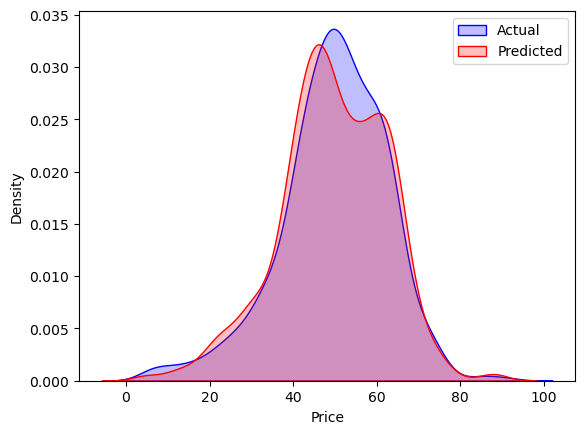

In [5]:
import seaborn as sns
sns.kdeplot(Y_test_reg, label='Actual', color='blue', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='red', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

Как видим дерево выбора показала очень хороший результат, она смогла качественно определить оба класса. 
Точность 0.82 показывает, что дерево выбора отлично подходит для классификации астероидов по опасности.

Дерево выбор с регрессией показало неплохой результат. Из графика видно, что она может предсказывать цены в широком окне значений. Но всё равно это хуже чем в KNN

## 3.Улучшение бейз лайнов 

### Классфикация

Для задачи классификации повторим действия из второй лабораторной

In [6]:
df_class['size'] = df_class[['est_diameter_min','est_diameter_max']].mean(axis=1)
df_class = df_class.drop(['est_diameter_min','est_diameter_max'],axis=1)

Смотрим на выбросы в магнитном поле объектов

In [7]:
from scipy import stats
from scipy.signal import savgol_filter

df_class = df_class[(np.abs(stats.zscore(df_class.drop(['hazardous'],axis=1))) < 3).all(axis=1)]

### Регрессия

В прошлой лабораторной я провёл достаточно хорошее улучшение бейзлайна регрессии, поэтому я его так же оставлю.

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Из лабораторной 1
df_reg = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/wind_vs_price.csv')
df_reg_price = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/da_price.csv')

df_reg = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/wind_vs_price.csv')
df_reg_price = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/da_price.csv')
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg = df_reg.drop(['AVG(dp.precio)', 'MIN(dp.precio)', 'MAX(dp.precio)'],axis=1)
df_reg = pd.merge(df_reg_price, df_reg, on='fecha', how='left')
df_reg = df_reg.dropna(how='any',axis=0)
df_reg['datetime_utc'] = pd.to_datetime(df_reg['datetime_utc'])
df_reg = df_reg.drop(['fecha', 'sistema', 'bandera', 'fecha_actualizacion'],axis=1)
# новый параметр дня недели
df_reg['date_of_week'] = df_reg['datetime_utc'].dt.day_name().astype('category').cat.codes
# новый параметр месяца
df_reg['month'] = df_reg['datetime_utc'].dt.month.astype('category').cat.codes
df_reg['datetime_utc'] = df_reg['datetime_utc'].astype(int)
# Объединение параметров ветра
df_reg['wind'] = df_reg[['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)']].mean(axis=1)
df_reg = df_reg.drop(['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)'],axis=1)

Давайте нормализуем эти две колонки через Z оценку. Это должно повлиять на качество предсказания

In [9]:
df_reg = df_reg[(np.abs(stats.zscore(df_reg[['precio', 'wind']])) < 3).all(axis=1)]

## Итоговые гипотезы

- Классификация
  - Объединение параметров размера астероида
  - Z-оценка
- Регрессия
  - Объединение таблицы цены и силы ветра
  - Объединение параметров среднего и максимального силы ветра
  - Z-оценка
  - MinMaxScaling

## Обучение на улучшенном бейзлайне

Делим датасет

In [10]:
# classification
Y_class = df_class['hazardous'].astype(int)
scaler = MinMaxScaler()
X_class = df_class.drop(['hazardous'],axis=1)
X_reg = scaler.fit_transform(X_class)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_reg,Y_class,random_state=24314,test_size=0.5, shuffle = True)
# regression
Y_reg = df_reg['precio']
scaler = MinMaxScaler()
X_reg = df_reg.drop(['precio'],axis=1)
X_reg = scaler.fit_transform(X_reg)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучаем модели

In [11]:
line_reg = DecisionTreeRegressor() 
line_reg.fit(X_train_reg, Y_train_reg)

log_reg = DecisionTreeClassifier()
log_reg.fit(X_train_class, Y_train_class)

DecisionTreeClassifier()

### Оценим классификацию

In [12]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class,predicted_class))
print("Classification CM score\n================\n",metrics.confusion_matrix(Y_test_class,predicted_class))
print("================\nClassification F1 score = ",metrics.f1_score(Y_test_class,predicted_class, average='weighted'))

Classification accuracy score =  0.8391152502910361
Classification CM score
 [[3651  708]
 [ 674 3557]]
Classification F1 score =  0.8391222195616982


Нам удалось повысить немного F1 Score, но незначительно

### Оценка предсказания

MSE score =  21.949501279817344
R2 score =  0.8870522466630726


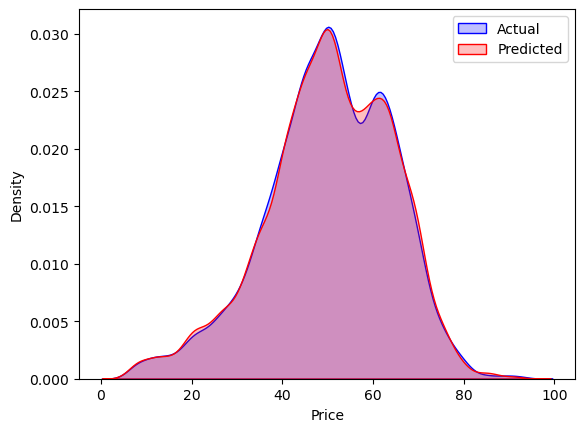

In [13]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))

import seaborn as sns
sns.kdeplot(Y_test_reg, label='Actual', color='blue', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='red', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

Дерево выбор стало отлично работать на улучшенном бейзлайне. Точность предскзаания выросла почти в 2 раза.

# Имплементация алгоритма машинного обучения

***Дерево выбора с регрессией***

In [14]:
import numpy as np

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        if len(set(y)) == 1:
            return y[0]
        
        if self.max_depth and depth >= self.max_depth:
            return np.mean(y)

        if len(y) < self.min_samples_split:
            return np.mean(y)

        best_split = self._find_best_split(X, y)
        if not best_split:
            return np.mean(y)

        left_indices = best_split['left_indices']
        right_indices = best_split['right_indices']
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_child,
            'right': right_child
        }

    def _find_best_split(self, X, y):
        best_split = {}
        best_mse = float('inf')

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y = y[left_indices]
                right_y = y[right_indices]
                mse = self._calculate_mse(left_y, right_y)

                if mse < best_mse:
                    best_mse = mse
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices
                    }
        
        return best_split

    def _calculate_mse(self, left_y, right_y):
        left_mean = np.mean(left_y)
        right_mean = np.mean(right_y)
        left_mse = np.mean((left_y - left_mean) ** 2)
        right_mse = np.mean((right_y - right_mean) ** 2)
        total_mse = (left_mse * len(left_y) + right_mse * len(right_y)) / (len(left_y) + len(right_y))
        return total_mse

    def _predict(self, x, tree):
        if not isinstance(tree, dict):
            return tree

        feature_index = tree['feature_index']
        threshold = tree['threshold']

        if x[feature_index] <= threshold:
            return self._predict(x, tree['left'])
        else:
            return self._predict(x, tree['right'])


***Дерево выбора для классификации***

In [15]:
import numpy as np

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        if len(set(y)) == 1:
            return y[0]
        
        if self.max_depth and depth >= self.max_depth:
            return self._majority_vote(y)

        if len(y) < self.min_samples_split:
            return self._majority_vote(y)

        best_split = self._find_best_split(X, y)
        if not best_split:
            return self._majority_vote(y)

        left_indices = best_split['left_indices']
        right_indices = best_split['right_indices']
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_child,
            'right': right_child
        }

    def _find_best_split(self, X, y):
        best_split = {}
        best_gini = float('inf')

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_y = y[left_indices]
                right_y = y[right_indices]
                gini = self._calculate_gini(left_y, right_y)

                if gini < best_gini:
                    best_gini = gini
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices
                    }
        
        return best_split

    def _calculate_gini(self, left_y, right_y):
        def gini_impurity(y):
            classes, counts = np.unique(y, return_counts=True)
            p = counts / len(y)
            return 1 - np.sum(p**2)

        left_gini = gini_impurity(left_y)
        right_gini = gini_impurity(right_y)
        total_gini = (left_gini * len(left_y) + right_gini * len(right_y)) / (len(left_y) + len(right_y))
        return total_gini

    def _majority_vote(self, y):
        classes, counts = np.unique(y, return_counts=True)
        return classes[np.argmax(counts)]

    def _predict(self, x, tree):
        if not isinstance(tree, dict):
            return tree

        feature_index = tree['feature_index']
        threshold = tree['threshold']

        if x[feature_index] <= threshold:
            return self._predict(x, tree['left'])
        else:
            return self._predict(x, tree['right'])


### Обучение и оценка модели

In [16]:
df_class = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/sameepvani/nasa-nearest-earth-objects/versions/2/neo_v2.csv')
df_reg = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/wind_vs_price.csv')

# В классификации избавляемся от столбцов, не влияющих на результат (различные названия и имена)
df_class = df_class.drop(['orbiting_body','sentry_object', 'name', 'id'],axis=1)
df_class = df_class.sort_values('hazardous', ascending=False).head(2*df_class['hazardous'].value_counts().get(True, 0))

# # В регрессии переводим даты в timestamp и уберём данные после 2019 года, так как там произошёл короновирус
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg['time'] = pd.to_datetime(df_reg['fecha']).astype(int)
df_reg = df_reg.drop(['fecha', 'MIN(dp.precio)', 'MAX(dp.precio)'], axis = 1)

# classification
#df_class = df_class.sort_values('hazardous', ascending=False).head(2*df_class['hazardous'].value_counts().get(True, 0))
Y_class = df_class['hazardous'].astype(int)
X_class = df_class.drop(['hazardous'],axis=1)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class,Y_class,random_state=24,test_size=0.5, shuffle = True)
# regression
Y_reg = df_reg['AVG(dp.precio)']
X_reg = df_reg.drop(['AVG(dp.precio)'],axis=1)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучение моделей

In [17]:
line_reg = MyDecisionTreeRegressor() 
line_reg.fit(X_train_reg.to_numpy(), Y_train_reg.to_numpy())

log_reg = MyDecisionTreeClassifier()
log_reg.fit(X_train_class.to_numpy(), Y_train_class.to_numpy())

In [18]:
predicted_class = log_reg.predict(X_test_class.to_numpy())
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class.to_numpy(),predicted_class))
print("Classification CM score\n================\n",metrics.confusion_matrix(Y_test_class.to_numpy(),predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class.to_numpy(),predicted_class, average='weighted'))

Classification accuracy score =  0.8855203619909502
Classification CM score
 [[3447  966]
 [  46 4381]]
Classification F1 score =  0.8842473461544672


Оценка регрессии

MSE score =  62.48254812643434
R2 score =  0.6181484745535242


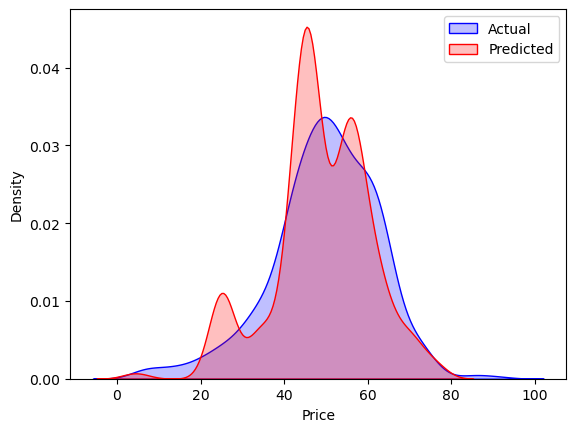

In [19]:
predicted_reg = line_reg.predict(X_test_reg.to_numpy())
print("MSE score = ",metrics.mean_squared_error(Y_test_reg.to_numpy(), predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg.to_numpy(), predicted_reg))
sns.kdeplot(Y_test_reg, label='Actual', color='blue', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='red', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

### Как видим собственные модели регрессии показали результаты даже лучше, чем библиотечные реализации. Но задача регрессии была решена значительно нестабильнее, чем библиотечная реализация

# Применяем улучшенный бейзлайн для собственных моделей

Бейз лайн классификации

In [20]:
df_class['size'] = df_class[['est_diameter_min','est_diameter_max']].mean(axis=1)
df_class = df_class.drop(['est_diameter_min','est_diameter_max'],axis=1)
df_class = df_class[(np.abs(stats.zscore(df_class.drop(['hazardous'],axis=1))) < 3).all(axis=1)]

Бейз лайн регрессии

In [21]:
# Из лабораторной 1
df_reg = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/wind_vs_price.csv')
df_reg_price = pd.read_csv('/Users/denisfadeev/.cache/kagglehub/datasets/pythonafroz/wind-speed-vs-spanish-power-prices/versions/2/da_price.csv')
df_reg = df_reg.drop(df_reg[df_reg.fecha > "2019-01-01"].index)
df_reg = df_reg.drop(['AVG(dp.precio)', 'MIN(dp.precio)', 'MAX(dp.precio)'],axis=1)
df_reg = pd.merge(df_reg_price, df_reg, on='fecha', how='left')
df_reg = df_reg.dropna(how='any',axis=0)
df_reg['datetime_utc'] = pd.to_datetime(df_reg['datetime_utc'])
df_reg = df_reg.drop(['fecha', 'sistema', 'bandera', 'fecha_actualizacion'],axis=1)
# новый параметр дня недели
df_reg['date_of_week'] = df_reg['datetime_utc'].dt.day_name().astype('category').cat.codes
# новый параметр месяца
df_reg['month'] = df_reg['datetime_utc'].dt.month.astype('category').cat.codes
df_reg['datetime_utc'] = df_reg['datetime_utc'].astype(int)
# Объединение параметров ветра
df_reg['wind'] = df_reg[['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)']].mean(axis=1)
df_reg = df_reg.drop(['AVG(wd.vel_km_h)','MAX(wd.racha_max_km_h)'],axis=1)
df_reg = df_reg[(np.abs(stats.zscore(df_reg[['precio', 'wind']])) < 3).all(axis=1)]

## Обучение своих моделей на улучшенных бейзалйнах

Готовим датасеты

In [22]:
# classification
Y_class = df_class['hazardous'].astype(int)
scaler = MinMaxScaler()
X_class = df_class.drop(['hazardous'],axis=1)
X_reg = scaler.fit_transform(X_class)
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_reg,Y_class,random_state=24314,test_size=0.5, shuffle = True)
# regression
Y_reg = df_reg['precio']
scaler = MinMaxScaler()
X_reg = df_reg.drop(['precio'],axis=1)
X_reg = scaler.fit_transform(X_reg)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg,Y_reg,random_state=24314,test_size=0.5, shuffle = True)

Обучение моделей

In [23]:
line_reg = MyDecisionTreeRegressor() 
line_reg.fit(X_train_reg, Y_train_reg.to_numpy())

log_reg = MyDecisionTreeClassifier()
log_reg.fit(X_train_class, Y_train_class.to_numpy())

Оценка классификации

In [24]:
predicted_class = log_reg.predict(X_test_class)
print("Classification accuracy score = ",metrics.accuracy_score(Y_test_class.to_numpy(),predicted_class))
print("Classification F1 score = ",metrics.f1_score(Y_test_class.to_numpy(),predicted_class, average='weighted'))

Classification accuracy score =  0.8869615832363213
Classification F1 score =  0.8858596801265705


Оценка регрессии

MSE score =  84.64115442391366
R2 score =  0.5644535103485256


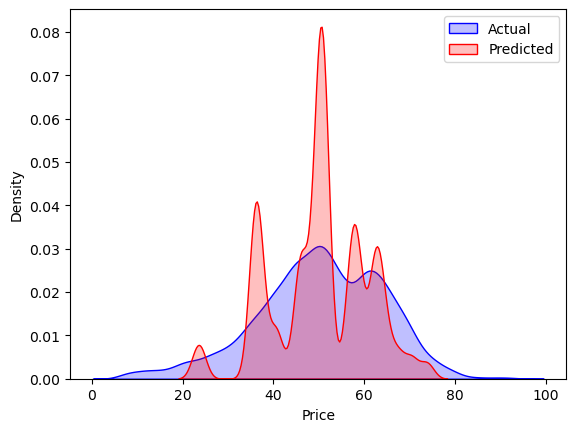

In [25]:
predicted_reg = line_reg.predict(X_test_reg)
print("MSE score = ",metrics.mean_squared_error(Y_test_reg, predicted_reg))
print("R2 score = ",metrics.r2_score(Y_test_reg, predicted_reg))
sns.kdeplot(Y_test_reg, label='Actual', color='blue', fill=True)
sns.kdeplot(predicted_reg, label='Predicted', color='red', fill=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

### Модель регрессии показала худший результат на улучшенном бейзлайне. 

# Сравнительные выводы

Соберём все лучшие результаты и метрики внутри одной таблицы чтобы провести итоговое сравнение всех моделей

|Модель|Метрики обычного бейзлайна|Метрики улучшенного бейзлайна|
|-|-|-|
|Дерево выбора|max_acc = 0.82 max_F1 = 0.82|max_acc = 0.83 max_F1 = 0.835|
|Моё дерево выбора|max_acc = 0.88 max_F1 = 0.85|max_acc = 0.886 max_F1 = 0.885|
|Дерево выбора для регрессии|min_MSE = 70.05 max_R2 = 0.57|min_MSE = 22.34 max_R2 = 0.88|
|Моё дерево выбор для регрессии|min_MSE = 62.48 max_R2 = 0.61|min_MSE = 84.641 max_R2 = 0.564|


В ходе лабораторной работы получилось добиться почти во всех случаях улучшения качества предсказания и классификации для моделей за счет улучшенного бейзлайна.
К удивлению, собственная реализация дерева выбора оказалась лучше, чем бибилиотечная реализация
При этом регрессия показала плохой результат, никакого улучшения на новом бейзлайне мы не получили.